# Multiple linear regression and collinearity

Scott Cole

8 May 2017

This notebook covers how to use python to analyze the relationship between multiple input variables and one output variable using multiple linear regression.

### Import libraries

We will be using the library [statsmodels](http://www.statsmodels.org/stable/index.html) to run our linear regression

In [1]:
import numpy as np
import statsmodels.formula.api as smf
import pandas as pd
import scipy as sp

%matplotlib notebook
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
import matplotlib.pyplot as plt

# 1. Regular linear regression

### 1a. Fitting a line

$y_i = \beta_0+\beta_1x_i+\epsilon_i$

In [2]:
# Define true statistics relating x and y
N_points = 10
true_beta0 = 0
true_beta1 = 2
noise_stdev = 1

# Set random seed
np.random.seed(0)

# Generate correlated data
x = np.random.randn(N_points) + 2
y = true_beta0 + true_beta1*x + np.random.randn(N_points)*noise_stdev

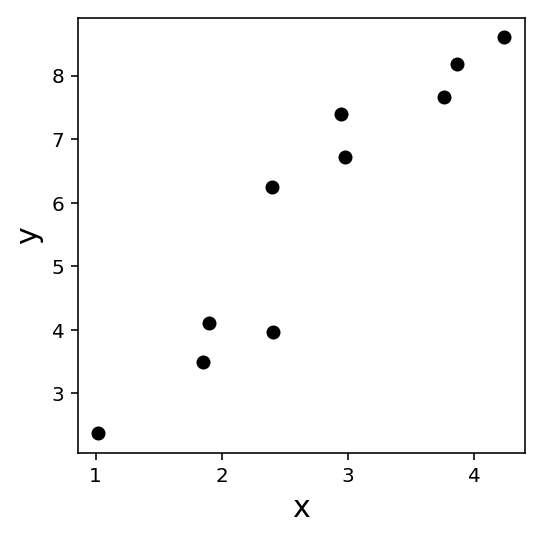

In [3]:
# Plot x and y
plt.figure(figsize=(4,4))
plt.plot(x, y, 'k.', ms=12)
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)

In [4]:
# Fit line to data
A = np.vstack([x, np.ones(len(x))]).T
m, b = np.linalg.lstsq(A, y)[0]
print('True statistics: y =', true_beta1, '*x +', true_beta0)
print('Estimated stats: y =', m, '*x +', b)
print('R squared (fraction of variance explained) =',np.round(sp.stats.pearsonr(x,y)[0],2))

True statistics: y = 2 *x + 0
Estimated stats: y = 2.04994401661 *x + 0.26389814044
R squared (fraction of variance explained) = 0.95


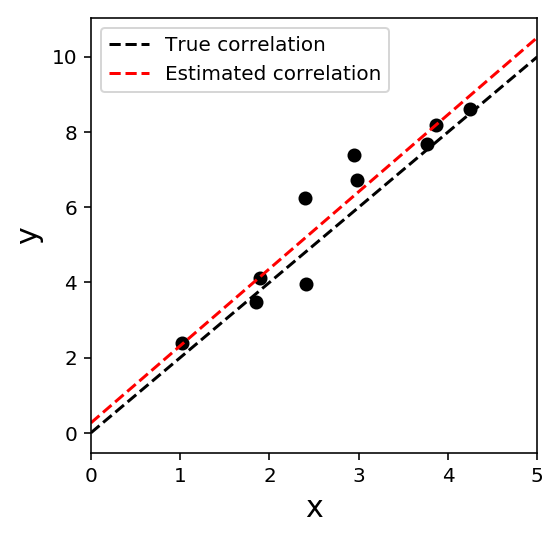

In [5]:
# Plot fitted line
plt.figure(figsize=(4,4))
plt.plot(x, y, 'k.', ms=12)
plt.plot([0,5], [true_beta1*x+true_beta0 for x in [0,5]], 'k--',label='True correlation')
plt.plot([0,5], [m*x+b for x in [0,5]], 'r--',label='Estimated correlation')
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.xlim((0,5))
plt.legend(loc='best')

### 1b. Outliers and normality of errors
Minimizing the squared error of the line fit works well if our data is normally distributed.

In this section, we simulate some data in which the error is not normally distributed, and see the fitted line is not as accurate.

In [6]:
# Simulate data with non-normal distribution of error
np.random.seed(1)
N_points = 100
x = np.random.randn(N_points) + 2
y = true_beta0 + true_beta1*x + np.random.randn(N_points)**2

In [7]:
# Fit line to data
A = np.vstack([x, np.ones(len(x))]).T
m, b = np.linalg.lstsq(A, y)[0]
print('True statistics: y =', true_beta1, '*x +', true_beta0)
print('Estimated stats: y =', m, '*x +', b)
print('R squared (fraction of variance explained) =',np.round(sp.stats.pearsonr(x,y)[0],2))

True statistics: y = 2 *x + 0
Estimated stats: y = 2.04202383003 *x + 0.805367000302
R squared (fraction of variance explained) = 0.82


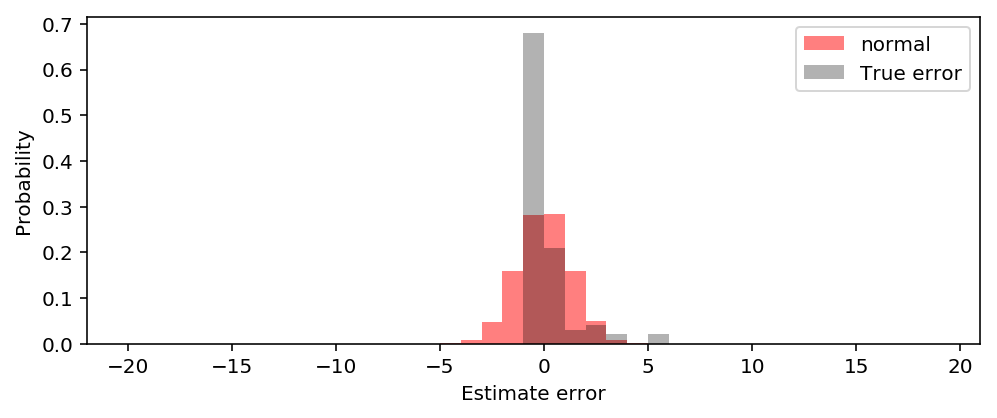

In [8]:
plt.figure(figsize=(8,3))
errors = y-[m*xi+b for xi in x]
hist2 = plt.hist(np.random.randn(100000)*np.std(errors),np.arange(-20,20,1),color='r',normed=True, alpha=.5,label='normal')
hist = plt.hist(errors,np.arange(-20,20,1),color='k',normed=True, alpha=.3,label='True error')
plt.legend(loc='best')
plt.xlabel('Estimate error')
plt.ylabel('Probability')

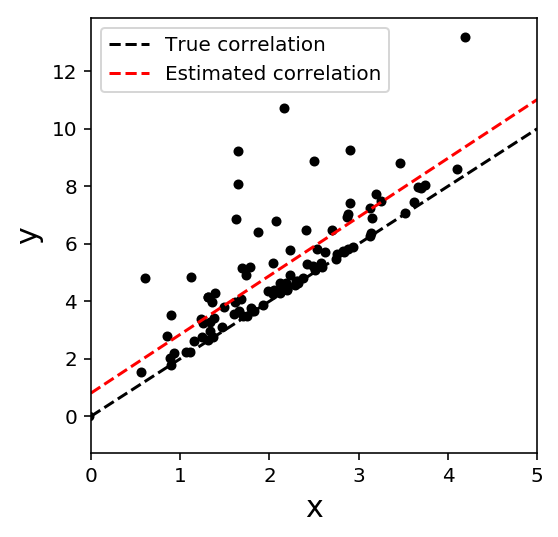

In [9]:
# Plot fitted line
plt.figure(figsize=(4,4))
plt.plot(x, y, 'k.', ms=8)
plt.plot([0,5], [true_beta1*x+true_beta0 for x in [0,5]], 'k--',label='True correlation')
plt.plot([0,5], [m*x+b for x in [0,5]], 'r--', label='Estimated correlation')
plt.xlabel('x',size=15)
plt.ylabel('y',size=15)
plt.xlim((0,5))
plt.legend(loc='best')

### 1c. Importance of independence of samples
Linear regression works well only if samples are [independent and identically distributed (IID)](https://en.wikipedia.org/wiki/Independent_and_identically_distributed_random_variables). If this assumption is violated, then the computed correlation statistics are not reliable.

In [10]:
# Burrito information
np.random.seed(1)
burrito1_cost = 6 + np.random.randn(100)
burrito1_stars = 3.5 + np.random.randn(100)*.5
burrito2_cost = 4
burrito2_stars = np.arange(4,5.1,.1)

# Define cost and stars arrays
c = np.append(np.ones(len(burrito2_stars))*burrito2_cost,burrito1_cost)
s = np.append(burrito2_stars,burrito1_stars)

# Compute correlation
print('R squared (fraction of variance explained) =',np.round(sp.stats.pearsonr(c,s)[0],2))
print('p =',np.round(sp.stats.pearsonr(c,s)[1],3))

R squared (fraction of variance explained) = -0.25
p = 0.009


(0, 10)

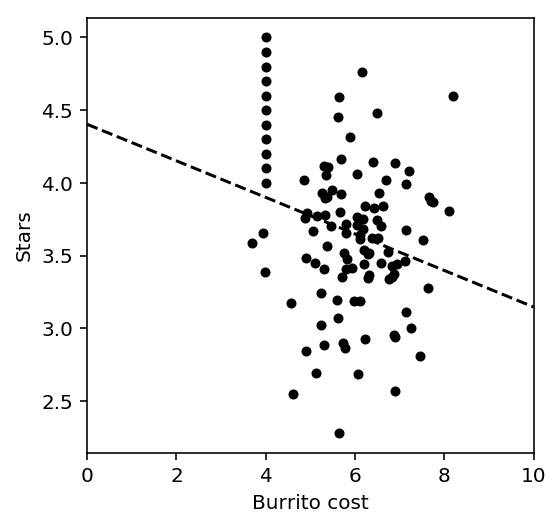

In [11]:
# Fit line to data
A = np.vstack([c, np.ones(len(c))]).T
m, b = np.linalg.lstsq(A, s)[0]

# Plot fitted line
plt.figure(figsize=(4,4))
plt.plot(c, s, 'k.', ms=8)
plt.plot([0,10], [m*x+b for x in [0,10]], 'k--')
plt.xlabel('Burrito cost')
plt.ylabel('Stars')
plt.xlim((0,10))

# 2. Multiple linear regression

### Load burritos

In [12]:
url = 'https://docs.google.com/spreadsheet/ccc?key=18HkrklYz1bKpDLeL-kaMrGjAhUM6LeJMIACwEljCgaw&output=csv'
df = pd.read_csv(url)

# Delete unreliable ratings
import pandasql
df.Unreliable = df.Unreliable.map({'x':1,'X':1,1:1})
df.Unreliable = df.Unreliable.fillna(0)
q = """SELECT * FROM df WHERE unreliable == 0"""
df = pandasql.sqldf(q.lower(), locals())

# Rename meat:filling column because statsmodels sucks
df.rename(columns={'Meat:filling': 'Meatratio'}, inplace=True)

# Limit data to main features
df = df[['Location','Burrito','Yelp','Cost','Hunger', 'Volume', 'Tortilla', 'Temp', 'Meat',
         'Fillings', 'Meatratio', 'Uniformity', 'Salsa', 'Synergy', 'Wrap', 'overall']]
df.tail()

,Location,Burrito,Yelp,Cost,Hunger,Volume,Tortilla,Temp,Meat,Fillings,Meatratio,Uniformity,Salsa,Synergy,Wrap,overall
306,Taco Villa,Carnitas,NaN,5.99,4.0,0.59,4.0,4.0,4.0,3.0,4.0,3.5,2.5,3.5,5.0,3.5
307,Lupe's Taco Shop,TGunz,NaN,10.00,3.0,1.54,3.0,4.0,3.2,3.5,1.8,1.8,3.5,3.7,3.5,3.9
308,Lupe's Taco Shop,TGunz,NaN,10.00,4.2,1.54,3.0,4.5,3.5,3.5,2.5,2.0,3.0,3.5,4.5,3.5
309,Filiberto's,Adobada,3.0,6.25,4.4,NaN,4.2,4.5,4.0,3.0,5.0,3.8,2.5,3.0,5.0,3.7
310,Filiberto's,California,NaN,6.25,3.0,NaN,4.5,4.5,3.7,3.5,4.0,3.5,3.0,4.0,4.5,4.0


### 2a. Individual linear regressions between burrito dimensions and overall satisfaction rating (BAD)
* Ignores redundant information across features
* Multiple comparison problem

In [13]:
# Define dimensions of interest
dims = ['Cost','Hunger', 'Tortilla', 'Temp', 'Meat',
        'Fillings', 'Meatratio', 'Uniformity', 'Salsa', 'Wrap']

# Correlate each dimension to the overall satisfaction rating
results = {}
for d in dims:
    model_str = 'overall ~ ' + d
    results[d] = smf.ols(model_str, data=df, missing='drop').fit()
    print(d,', R2 =',results[d].rsquared, ', p =',np.round(results[d].pvalues[d],4))

Cost , R2 = 0.023711482916 , p = 0.0071
Hunger , R2 = 0.0237099905646 , p = 0.0069
Tortilla , R2 = 0.134042259073 , p = 0.0
Temp , R2 = 0.0688476427895 , p = 0.0
Meat , R2 = 0.462036454737 , p = 0.0
Fillings , R2 = 0.52080645318 , p = 0.0
Meatratio , R2 = 0.271881239693 , p = 0.0
Uniformity , R2 = 0.178027143455 , p = 0.0
Salsa , R2 = 0.160192091587 , p = 0.0
Wrap , R2 = 0.0228518029439 , p = 0.008


In [14]:
#model_str
#results['Salsa']
#results['Salsa'].summary()
#plt.plot(df['Fillings'],df['overall'],'k.')

### 2b. Multiple linear regression
* Interpret coefficients

In [15]:
model_str = 'overall ~ ' + ' + '.join(dims)
results_all = smf.ols(model_str, data=df, missing='drop').fit()
print(results_all.summary())

                            OLS Regression Results                            
Dep. Variable:                overall   R-squared:                       0.723
Model:                            OLS   Adj. R-squared:                  0.712
Method:                 Least Squares   F-statistic:                     68.48
Date:                Thu, 04 May 2017   Prob (F-statistic):           2.25e-67
Time:                        18:57:05   Log-Likelihood:                -115.21
No. Observations:                 274   AIC:                             252.4
Df Residuals:                     263   BIC:                             292.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     -0.5042      0.245     -2.055      0.0

In [16]:
# dims = ['Cost','Hunger', 'Tortilla', 'Temp', 'Meat',
#         'Fillings', 'Meatratio', 'Uniformity', 'Salsa', 'Synergy', 'Wrap']
# model_str = 'overall ~ ' + ' + '.join(dims)
# results_all = smf.ols(model_str, data=df, missing='drop').fit()
# print(results_all.summary())

# 3. Regressing out
If you want to know if a feature contains significantly more information about the output, beyond what is contained in another feature, you can

### 3a. Correlation matrix

(0, 10)

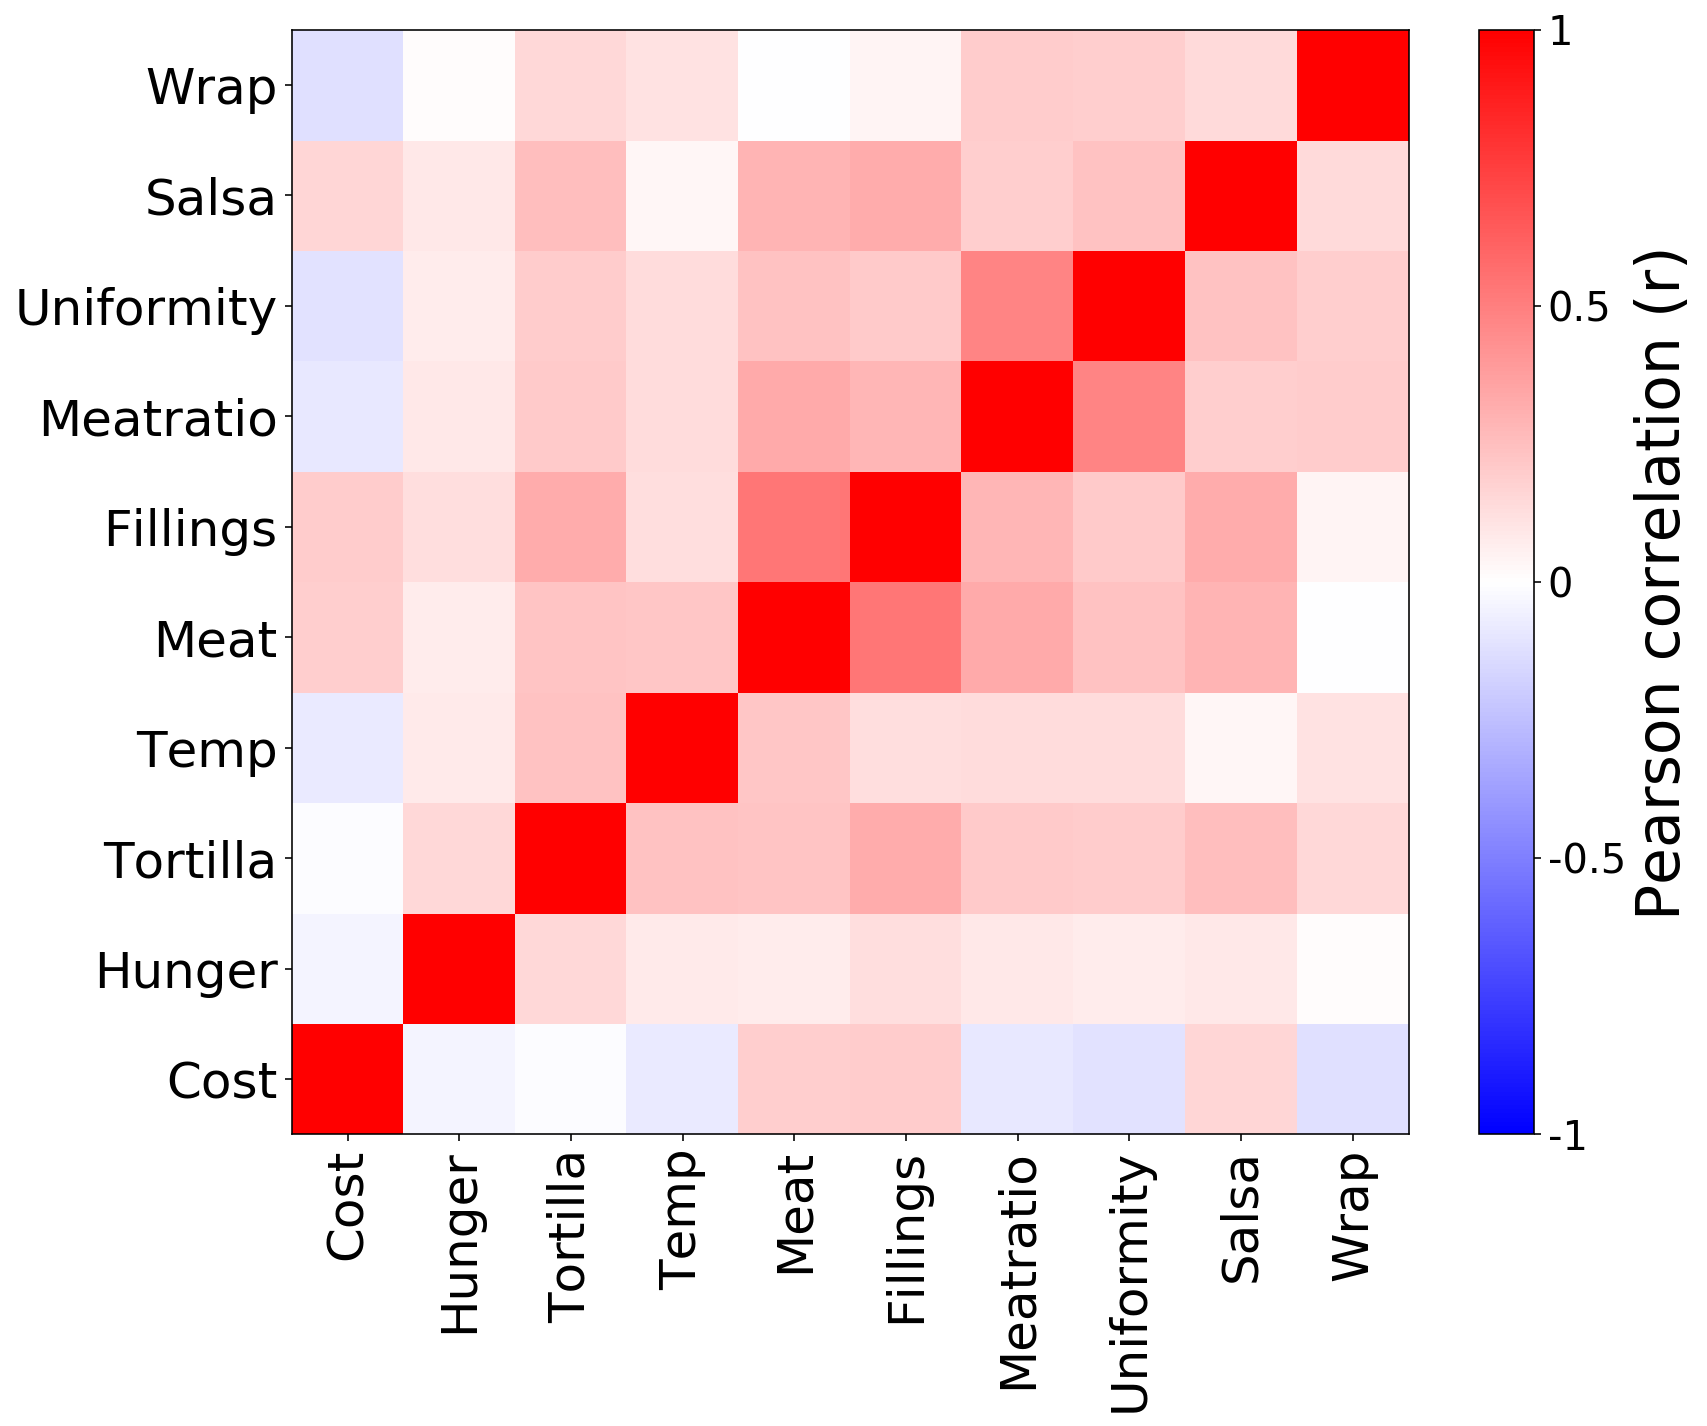

In [17]:
dfcorr = df[dims].corr()
M = len(dims)
from matplotlib import cm

clim1 = (-1,1)
plt.figure(figsize=(12,10))
cax = plt.pcolor(range(M+1), range(M+1), dfcorr, cmap=cm.bwr)
cbar = plt.colorbar(cax, ticks=(-1,-.5,0,.5,1))
cbar.ax.set_ylabel('Pearson correlation (r)', size=30)
plt.clim(clim1)
cbar.ax.set_yticklabels((-1,-.5,0,.5,1),size=20)
ax = plt.gca()
ax.set_yticks(np.arange(M)+.5)
ax.set_yticklabels(dims,size=25)
ax.set_xticks(np.arange(M)+.5)
ax.set_xticklabels(dims,size=25)
plt.xticks(rotation='vertical')
plt.tight_layout()
plt.xlim((0,M))
plt.ylim((0,M))

### 3b. Regress out cost from meat quality

In [18]:
NEED TO DO THIS PART

SyntaxError: invalid syntax (<ipython-input-18-366d366f6271>, line 1)

In [ ]:
plt.plot(df['Cost'],df['overall'],'k.',alpha=.2)